In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/Dataset/BFDORIGINAL.zip"

Streaming output truncated to the last 5000 lines.
  inflating: BFDORIGINAL/train/not fractured/50-rotated3-rotated1-rotated3.jpg  
  inflating: __MACOSX/BFDORIGINAL/train/not fractured/._50-rotated3-rotated1-rotated3.jpg  
  inflating: BFDORIGINAL/train/not fractured/68-rotated3-rotated3-rotated2.jpg  
  inflating: __MACOSX/BFDORIGINAL/train/not fractured/._68-rotated3-rotated3-rotated2.jpg  
  inflating: BFDORIGINAL/train/not fractured/40-rotated3-rotated2.jpg  
  inflating: __MACOSX/BFDORIGINAL/train/not fractured/._40-rotated3-rotated2.jpg  
  inflating: BFDORIGINAL/train/not fractured/34-rotated1-rotated2-rotated2.jpg  
  inflating: __MACOSX/BFDORIGINAL/train/not fractured/._34-rotated1-rotated2-rotated2.jpg  
  inflating: BFDORIGINAL/train/not fractured/43-rotated2-rotated2-rotated2-rotated1.jpg  
  inflating: __MACOSX/BFDORIGINAL/train/not fractured/._43-rotated2-rotated2-rotated2-rotated1.jpg  
  inflating: BFDORIGINAL/train/not fractured/30-rotated3-rotated1.jpg  
  inflating:

In [ ]:
import cv2
import os
import numpy as np
from tqdm import tqdm
import sklearn
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import ReduceLROnPlateau, TensorBoard, ModelCheckpoint

In [ ]:
img = cv2.imread("/content/BFDORIGINAL/train/fractured/10-rotated1-rotated1-rotated1.jpg")
img.shape

(224, 224, 3)

In [ ]:
base_path = "/content/BFDORIGINAL"
IMAGE_SIZE = 224
BATCH_SIZE = 12
VERBOSE = 1

In [ ]:
class_names = ["fractured", "not fractured"]

In [ ]:
x_train=[]
y_train=[]

for i in class_names:
    count = 0
    folder_path = os.path.join(os.path.join(base_path,"train"), i)
    for j in tqdm(os.listdir(folder_path), ncols=70):
        if count == 450:
          break
        count += 1
        img = cv2.imread(os.path.join(folder_path,j))
        img = cv2.resize(img, (IMAGE_SIZE,IMAGE_SIZE))
        x_train.append(img)
        y_train.append(i)
print('Train Dataset Loading complete')

for i in class_names:
    count = 0
    folder_path = os.path.join(os.path.join(base_path,"val"), i)
    for j in tqdm(os.listdir(folder_path), ncols=70):
        if count == 450:
          break
        count += 1
        img = cv2.imread(os.path.join(folder_path,j))
        img = cv2.resize(img, (IMAGE_SIZE,IMAGE_SIZE))
        x_train.append(img)
        y_train.append(i)
print('Test Dataset Loading complete')

x_train = np.array(x_train)
y_train = np.array(y_train)


x_train, y_train = sklearn.utils.shuffle(x_train, y_train, random_state=0)

 10%|██▉                          | 450/4383 [00:00<00:05, 734.87it/s]


Train Dataset Loading complete


100%|██████████████████████████████| 240/240 [00:00<00:00, 695.09it/s]


Test Dataset Loading complete


['fractured' 'not fractured']
[810 690]


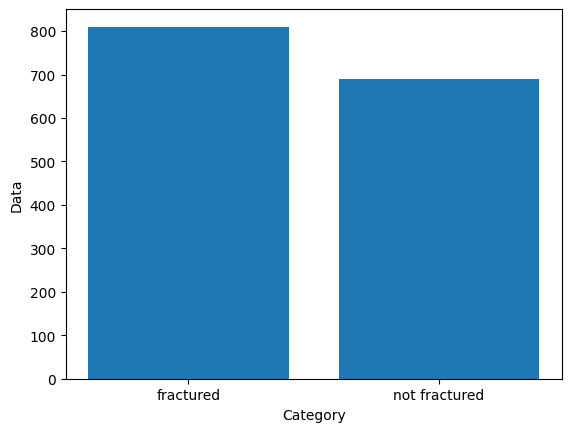

In [ ]:
unique, counts = np.unique(y_train, return_counts=True)
print(unique)
print(counts)
plt.bar(unique,counts,align='center')
plt.xlabel('Category')
plt.ylabel('Data')
plt.show()

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, random_state=47, test_size=0.10)

print("Shapes X : Train :",x_train.shape,  " Test :",x_test.shape)
print("Shapes Y : Train :",y_train.shape,  " Test :",y_test.shape)

Shapes X : Train : (1350, 224, 224, 3)  Test : (150, 224, 224, 3)
Shapes Y : Train : (1350,)  Test : (150,)


In [ ]:
y_train_new = [class_names.index(i) for i in y_train]
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = [class_names.index(i) for i in y_test]
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

In [ ]:
print(y_train[1])
print(y_train[2])

[0. 1.]
[1. 0.]


In [ ]:
print(np.argmax(y_train[1]))
print(np.argmax(y_train[2]))

1
0


In [ ]:
classes = np.unique(np.argmax(y_train, axis=1))
print(classes)

[0 1]


In [ ]:
mapping = dict(zip(classes, class_names))
mapping

{0: 'fractured', 1: 'not fractured'}

In [ ]:
inputShape = (IMAGE_SIZE, IMAGE_SIZE, 3)
iv3 = InceptionV3(weights="imagenet", input_shape=inputShape, include_top=False)

87910968/87910968 [==============================] - 0s 0us/step


In [ ]:
model = iv3.output
model = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(model)
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(0.5)(model)
model = tf.keras.layers.Dense(len(classes), activation='softmax')(model)
model = tf.keras.models.Model(inputs=iv3.input, outputs=model)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 111, 111, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 111, 111, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 111, 111, 32)         0         ['batch_normalization[0][0

In [ ]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("inception.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,mode='auto',verbose=VERBOSE)

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
history = model.fit(x_train, y_train, batch_size=BATCH_SIZE,validation_data=(x_test, y_test), steps_per_epoch=len(x_train) // BATCH_SIZE,epochs=12, callbacks=[reduce_lr, checkpoint, tensorboard])

Epoch 1/12
112/112 [==============================] - ETA: 0s - loss: 0.8034 - accuracy: 0.5997
Epoch 1: val_accuracy improved from -inf to 0.43333, saving model to vgg16.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


112/112 [==============================] - 816s 7s/step - loss: 0.8034 - accuracy: 0.5997 - val_loss: 4.5244 - val_accuracy: 0.4333 - lr: 0.0010
Epoch 2/12
112/112 [==============================] - ETA: 0s - loss: 0.5613 - accuracy: 0.7250
Epoch 2: val_accuracy did not improve from 0.43333
112/112 [==============================] - 786s 7s/step - loss: 0.5613 - accuracy: 0.7250 - val_loss: 0.8370 - val_accuracy: 0.4200 - lr: 0.0010
Epoch 3/12
112/112 [==============================] - ETA: 0s - loss: 0.5132 - accuracy: 0.7549
Epoch 3: val_accuracy improved from 0.43333 to 0.64667, saving model to vgg16.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


112/112 [==============================] - 769s 7s/step - loss: 0.5132 - accuracy: 0.7549 - val_loss: 1.0202 - val_accuracy: 0.6467 - lr: 0.0010
Epoch 4/12
 52/112 [============>.................] - ETA: 6:35 - loss: 0.6239 - accuracy: 0.6424

KeyboardInterrupt: 

In [ ]:
epochs = [i for i in range(12)]
fig, ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(14, 7)

ax[0].plot(epochs, train_acc, 'go-', label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, 'ro-', label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

ax[1].plot(epochs, train_loss, 'g-o', label ='Training Loss')
ax[1].plot(epochs, val_loss, 'r-o', label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')
plt.show()

In [ ]:
result = model.evaluate(x_test, y_test)
print("Testing Loss :", result[0])
print("Testing Accuracy :", result[1]*100, "%")

In [ ]:
predictions = model.predict(x_test)
predictions = np.argmax(predictions, axis = 1)
y_test_edit = np.argmax(y_test , axis = 1)

In [ ]:
cf_report = sklearn.metrics.classification_report(y_test_edit, predictions)
print(cf_report)

In [ ]:
import sklearn
import seaborn as sns
cf_matrix = sklearn.metrics.confusion_matrix(y_test_edit, predictions)
sns.heatmap(cf_matrix, cmap = 'Blues', linewidth = 1, annot = True, xticklabels=class_names, yticklabels=class_names)

In [ ]:
!pip install shap

In [ ]:
import shap

In [ ]:
shap.initjs()

In [ ]:
masker = shap.maskers.Image("inpaint_telea", x_train[0].shape)

explainer = shap.Explainer(model, masker, output_names=class_names)

explainer

In [ ]:
shap_values = explainer(x_test[:1], outputs=shap.Explanation.argsort.flip[:5])

shap_values.shape

In [ ]:
print("Actual Labels    : {}".format([mapping[i] for i in np.argmax(y_test[:4], axis=1)]))
probs = model.predict(x_test[:1])
print("Predicted Labels : {}".format([mapping[i] for i in np.argmax(probs, axis=1)]))
print("Probabilities : {}".format(np.max(probs, axis=1)))

In [ ]:
shap.image_plot(shap_values)

In [ ]:
masker = shap.maskers.Image("inpaint_ns", x_train[0].shape)

explainer = shap.Explainer(model, masker, output_names=class_names)

shap_values = explainer(x_test[:1], outputs=shap.Explanation.argsort.flip[:5])

shap.image_plot(shap_values)

In [ ]:
masker = shap.maskers.Image("blur(28,28)", x_train[0].shape)

explainer = shap.Explainer(model, masker, output_names=class_names)

shap_values = explainer(x_test[:1], outputs=shap.Explanation.argsort.flip[:5])

shap.image_plot(shap_values)

In [ ]:
def input_img(image):
  image = tf.expand_dims(image, axis=0)
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, [224,224])
  return image

def normalize_image(img):
  grads_norm = img[:,:,0]+ img[:,:,1]+ img[:,:,2]
  grads_norm = (grads_norm - tf.reduce_min(grads_norm))/ (tf.reduce_max(grads_norm)-
  tf.reduce_min(grads_norm))
  return grads_norm

def plot_maps(img1, img2,vmin=0.3,vmax=0.7, mix_val=2):
  f = plt.figure(figsize=(15,45))
  plt.subplot(1,3,1)
  plt.imshow(img1,vmin=vmin, vmax=vmax, cmap="ocean")
  plt.axis("off")
  plt.subplot(1,3,2)
  plt.imshow(img2, cmap = "ocean")
  plt.axis("off")
  plt.subplot(1,3,3)
  plt.imshow(img1*mix_val+img2/mix_val, cmap = "ocean" )
  plt.axis("off")

In [ ]:
input_img = input_img(x_test[0]) # Hardcoded Test Image 0

In [ ]:
plt.imshow(normalize_image(input_img[0]), cmap = "ocean")

In [ ]:
result = model(input_img)
max_idx = tf.argmax(result,axis = 1)

In [ ]:
result

In [ ]:
max_idx

In [ ]:
with tf.GradientTape() as tape:
  tape.watch(input_img)
  result = model(input_img)
  max_score = result[0,max_idx[0]]

In [ ]:
max_score

In [ ]:
grads = tape.gradient(max_score, input_img)

In [ ]:
grads

In [ ]:
plot_maps(normalize_image(grads[0]), normalize_image(input_img[0]))